In [2]:
import os
import math
import random
import seaborn
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from collections import namedtuple


In [137]:
df = pd.read_excel("M3C.xls", usecols="A:Z")

df_micro = df.iloc[0:146,]
df_micro = df_micro.iloc[:,6:27]

In [138]:
# Smoothing
#df_train_unsmoothed = df_train.to_numpy().reshape(-1,14)
def exponential_smoothing(data, alpha=0.8):
    data = pd.DataFrame(data)
    return data.ewm(alpha=alpha, adjust=False).mean()
df_micro = exponential_smoothing(df_micro)

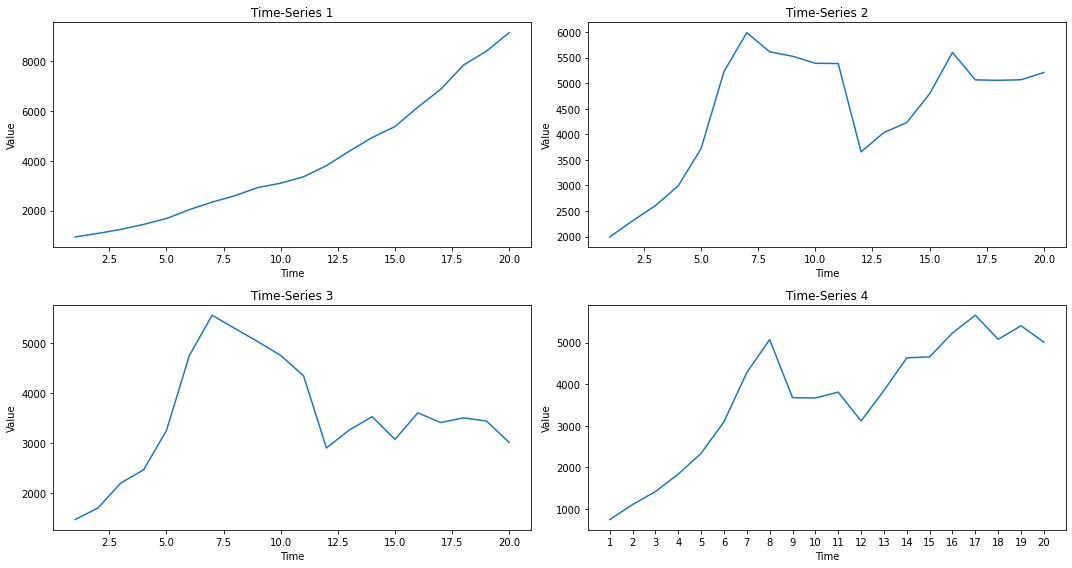

In [82]:
num_rows = 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(df_micro):
        ax.plot(df_micro.iloc[i])
        ax.set_title(f"Time-Series {i+1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
    else:
        ax.axis("off")

plt.tight_layout()
plt.xticks(list(range(1, 21)))
plt.show()

In [139]:
df_train = df_micro.iloc[:,:-6]
df_test = df_micro.iloc[:, -6:]

In [140]:
from sklearn.preprocessing import MinMaxScaler

def standardize_data_sliding_window(train_x, val_x):
    scaler = MinMaxScaler()
    scaler.fit(train_x)
    train_x_scaled = scaler.transform(train_x)
    val_x_scaled = scaler.transform(val_x)
    return train_x_scaled, val_x_scaled, scaler

In [87]:
def standardising(data):
    # Standardising
    scaler = StandardScaler()
    data = scaler.fit_transform(data.to_numpy().reshape(-1,1))
    data = pd.DataFrame(data)
    mean = scaler.mean_
    std = scaler.scale_
    return data, mean, std

In [88]:
def preprocess_data(data, mean=None, std=None):
    data = exponential_smoothing(data)
    if mean == None and std == None:
        data, mean, std = standardising(data)
    else:
        data = (data - mean) / std
    return data, mean, std

In [141]:
df_train = df_train.to_numpy().reshape(-1,14)
df_test = df_test.to_numpy().reshape(-1,6)

In [ ]:
num_rows = 2
num_cols = 2

smoothed_graphs = [3, 6, 15, 99]
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
counter = 0
for i, ax in enumerate(axes):
    if i < len(df_micro):
        ax.plot(df_train_unsmoothed[smoothed_graphs[counter]], label="Original Data")
        ax.plot(df_train[smoothed_graphs[counter]], label="Smoothed Data")
        ax.set_title(f"Time-Series {smoothed_graphs[counter]}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend()
    else:
        ax.axis("off")
    counter = counter + 1

plt.tight_layout()
plt.show()

In [90]:
def get_labelled_window(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon]

def make_windows(x, window_size=4, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of window size
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)
  return windows.reshape(-1,4), labels.reshape(-1,1)

In [142]:
train_x = []
train_y = []
test_x = []
test_y = []

for i in range(len(df_train)):
    windows_train, labels_train = make_windows(df_train[i], window_size=4, horizon=1)
    windows_test, labels_test = make_windows(df_test[i], window_size=4, horizon=1)
    train_x = np.concatenate((np.array(train_x).reshape(-1,4), windows_train.reshape(-1,4)))
    train_y = np.concatenate((np.array(train_y).reshape(-1,1), labels_train.reshape(-1,1)))
    test_x = np.concatenate((np.array(test_x).reshape(-1,4), windows_test.reshape(-1,4)))
    test_y = np.concatenate((np.array(test_y).reshape(-1,1), labels_test.reshape(-1,1)))

3446.4638561643837

In [180]:
# SMAPE
def evaluate_smape(y_true, y_pred):
    numerator = tf.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true))/2
    smape = tf.reduce_mean(numerator / denominator) * 100
    return smape

def smape_loss(y_true, y_pred):
    numerator = tf.abs(y_pred - y_true)
    denominator = ((y_pred + y_true)/2) + 0.1
    smape = tf.reduce_mean(numerator / denominator)
    return smape

def metric_mdape(y_true, y_pred):
    return tfp.stats.percentile((tf.abs(tf.math.subtract(y_true, y_pred)/ y_true)), 50.0, interpolation='midpoint')
      
def evaluate_mdape(y_true, y_pred):
    return np.median((np.abs(np.subtract(y_true, y_pred)/ y_true))) * 100

def evaluate_pred(y_true, y_pred):
    # Symmetric mean absolute percentage error
    smape = evaluate_smape(y_true, y_pred)
    # Median symmetric absolute percentage error
    mdape = evaluate_mdape(y_true, y_pred)
    return smape, mdape

In [93]:
# Destandardise
def de_standardise(data, mean, std):
    return data * std + mean

def standardise(data, mean, std):
    return (data - mean) / std

In [94]:
# Hyperparameters
Combination = namedtuple("Combination", "learning_rate batch_size regularization hidden_layers hidden_neurons")

learning_rates = np.array([0.001, 0.01, 0.1])
batch_sizes = np.array([16, 32, 64, 128])
regularizations = np.array([0.001, 0.01, 0.001])
hidden_layers = np.array([2, 3, 4, 5, 6, 8]) #2, 3, 4, 6, 8
hidden_neurons = np.array([2, 3, 4, 5])

combinations = list(itertools.starmap(Combination, itertools.product(learning_rates, batch_sizes, regularizations, hidden_layers, hidden_neurons)))

In [182]:
# Time-series expanding window validation
#with tf.device('/cpu:0'):
    
tf.random.set_seed(42)
eval_scores = []
tscv = TimeSeriesSplit(n_splits=5)
def cross_validation(combination, train_x=train_x, train_y=train_y, tscv=tscv):
    smape_scores = []
    mdape_scores = []

    # Cross-Validation
    for train_index, test_index in tscv.split(train_x):
        train_x_cv, val_x_cv = train_x[train_index], train_x[test_index]
        train_y_cv, val_y_cv = train_y[train_index], train_y[test_index]

        # Pre-Processing
        #train_x_scaled, val_x_scaled, scaler = standardize_data_sliding_window(train_x_cv, val_x_cv)
        scaler = StandardScaler()
        train_x_cv = scaler.fit_transform(train_x_cv)
        val_x_cv = scaler.transform(val_x_cv)


        model_cv = tf.keras.Sequential(name="model")
        model_cv.add(tf.keras.layers.InputLayer(input_shape=(4,)))

        for i in range(combination.hidden_layers):
            model_cv.add(tf.keras.layers.Dense(combination.hidden_neurons, 
                                            activation="relu", 
                                            kernel_initializer=tf.initializers.HeNormal(), 
                                            kernel_regularizer=tf.keras.regularizers.l2(combination.regularization)))
        model_cv.add(tf.keras.layers.Dense(1, activation="linear", 
                                        kernel_initializer=tf.initializers.HeNormal(), 
                                        kernel_regularizer=tf.keras.regularizers.l2(combination.regularization)))


        model_cv.compile(loss=smape_loss,
                        optimizer=tf.keras.optimizers.Adam(learning_rate=combination.learning_rate),
                        metrics=[metric_mdape, "mae", "mse"]) # Backpropagation
        
        model_cv.fit(train_x_cv, train_y_cv, epochs=50, batch_size=combination.batch_size, verbose=0)

        predictions = model_cv.predict(val_x_cv)
        #predictions = predictions * std + mean
        #print(predictions)
        smape_score, mdape_score = evaluate_pred(val_y_cv, predictions)
        
        smape_scores.append(smape_score)
        mdape_scores.append(mdape_score)
        
    mean_smape = np.mean(smape_scores)
    mean_mdape = np.mean(mdape_scores)
    hyperparameters = {
        'learning_rate': combination.learning_rate,
        'batch_size': combination.batch_size,
        'regularization': combination.regularization,
        'hidden_neurons': combination.hidden_neurons,
        'hidden_layers': combination.hidden_layers
    }
    print(f"Current mean SMAPE: {mean_smape}, Current hyperparameters: {hyperparameters}")
    return mean_smape, mean_mdape, hyperparameters

random_combinations = random.sample(combinations, 5)
results = map(cross_validation, random_combinations)

optimal_smape = float('inf')
optimal_mdape = float('inf')
optimal_hyperparameters = {}
for result in results:
    smape, mdape, hyperparameters = result
    if smape < optimal_smape:
        optimal_smape = smape
        optimal_mdape = mdape
        optimal_hyperparameters = hyperparameters
print("Best Hyperparameters:", optimal_hyperparameters)
print("Best SMAPE Score:", optimal_smape)
print("Best MDAPE Score:", optimal_mdape)

8/8 [==============================] - 0s 913us/step
Current mean SMAPE: 32.83932635725934, Current hyperparameters: {'learning_rate': 0.1, 'batch_size': 32, 'regularization': 0.001, 'hidden_neurons': 3, 'hidden_layers': 8}
8/8 [==============================] - 0s 961us/step
Current mean SMAPE: 83.76833870645866, Current hyperparameters: {'learning_rate': 0.1, 'batch_size': 128, 'regularization': 0.01, 'hidden_neurons': 3, 'hidden_layers': 6}
8/8 [==============================] - 0s 1ms/step
Current mean SMAPE: 14.959455354223035, Current hyperparameters: {'learning_rate': 0.01, 'batch_size': 64, 'regularization': 0.001, 'hidden_neurons': 5, 'hidden_layers': 6}
8/8 [==============================] - 0s 994us/step
Current mean SMAPE: 59.1754839805782, Current hyperparameters: {'learning_rate': 0.001, 'batch_size': 16, 'regularization': 0.001, 'hidden_neurons': 3, 'hidden_layers': 6}
8/8 [==============================] - 0s 985us/step
Current mean SMAPE: 191.6605284013042, Current hyp

In [185]:
print(f"Regularization: {optimal_hyperparameters['regularization']}")
print(f"Learning Rate: {optimal_hyperparameters['learning_rate']}")
print(f"Batch Size: {optimal_hyperparameters['batch_size']}")
print(f"Hidden Layers: {optimal_hyperparameters['hidden_layers']}")
print(f"Hidden Neurons: {optimal_hyperparameters['hidden_neurons']}")

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(4,))
], name="model")

for i in range(optimal_hyperparameters["hidden_layers"]):
    model.add(tf.keras.layers.Dense(optimal_hyperparameters["hidden_neurons"], 
                                    activation="relu", 
                                    kernel_initializer=tf.initializers.HeNormal(), 
                                    kernel_regularizer=tf.keras.regularizers.l2(optimal_hyperparameters["regularization"])))
model.add(tf.keras.layers.Dense(1, activation="linear", 
                                kernel_initializer=tf.initializers.HeNormal(), 
                                kernel_regularizer=tf.keras.regularizers.l2(optimal_hyperparameters["regularization"])))

print()
model.compile(loss=smape_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=optimal_hyperparameters["learning_rate"]), 
                metrics=[metric_mdape, "mae", "mse"]) # Backpropagation

early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=25)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_2.hdf5', monitor='loss', mode='min', verbose=1, save_best_only=True)

mean = np.mean(train_x)
std = np.std(train_x)
train_x_t = (train_x - mean) / std
#train_y_t = (train_y - mean) / std
# Train the model on the full training dataset
model.fit(train_x_t, train_y, epochs=200, batch_size=optimal_hyperparameters["batch_size"], verbose=1, callbacks=[early_stopping, model_checkpoint])

Regularization: 0.001
Learning Rate: 0.01
Batch Size: 64
Hidden Layers: 6
Hidden Neurons: 5

Epoch 1/200
 1/23 [>.............................] - ETA: 28s - loss: 0.8120 - metric_mdape: 1.0000 - mae: 0.8073 - mse: 1.0835
Epoch 1: loss improved from inf to -65.31683, saving model to best_model_2.hdf5
23/23 [==============================] - 1s 3ms/step - loss: -65.3168 - metric_mdape: 0.9322 - mae: 0.8679 - mse: 1.2663
Epoch 2/200
 1/23 [>.............................] - ETA: 0s - loss: 0.4472 - metric_mdape: 0.8452 - mae: 0.9669 - mse: 1.3551
Epoch 2: loss did not improve from -65.31683
23/23 [==============================] - 0s 2ms/step - loss: 2.2682 - metric_mdape: 1.2952 - mae: 1.0412 - mse: 1.7421
Epoch 3/200
 1/23 [>.............................] - ETA: 0s - loss: 2.2838 - metric_mdape: 2.3898 - mae: 1.2638 - mse: 2.3492
Epoch 3: loss did not improve from -65.31683
23/23 [==============================] - 0s 2ms/step - loss: 1.9805 - metric_mdape: 1.6827 - mae: 1.1283 - mse: 2.1

In [55]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_439 (Dense)           (None, 5)                 25        
                                                                 
 dense_440 (Dense)           (None, 5)                 30        
                                                                 
 dense_441 (Dense)           (None, 5)                 30        
                                                                 
 dense_442 (Dense)           (None, 5)                 30        
                                                                 
 dense_443 (Dense)           (None, 5)                 30        
                                                                 
 dense_444 (Dense)           (None, 1)                 6         
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params:

In [166]:
def autoregression(model, x, horizon=6):
    standardised_x = (x - mean) / std
    for i in range(horizon):
        forecast = model.predict(np.array(standardised_x))
        pred = np.array([tf.squeeze(forecast).numpy()])
        standardised_x = np.concatenate((standardised_x, pred))
    return standardised_x


In [187]:
forecast = model.predict(np.array((test_x - mean) / std))
pred = np.array([tf.squeeze(forecast).numpy()])
#te
#autoregression(model, test_x, 1)
#test_x
res = pred.reshape(-1,1)
lol = evaluate_smape(test_y, res)
lol

10/10 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=30.01036030913647>

In [167]:
autoregression(model, test_x, 1)

10/10 [==============================] - 0s 1ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 292

In [162]:
predictions = []
def evaluate_model_on_test(model, df_train=df_train, df_test=df_test, horizon=6):
    smape_scores = []
    mdape_scores = []
    
    for i in range(len(df_train)):
        window = df_train[i][10:14]
        labels = df_test[i][0:horizon]
        test_preds = autoregression(model, window, horizon)
        print(f"Destandardised test pred: {test_preds}")
        print(f"Labels: {labels}")
        print(f"Full Labels: {df_test[i]}")
        print(f"Window: {window}")
        predictions.append(de_standardise(test_preds))
        smape_score, mdape_score = evaluate_pred(labels[horizon-1], de_standardise(test_preds[horizon-1]))
        smape_scores.append(smape_score)
        mdape_scores.append(mdape_score)
        print(f"Current mean SMAPE: {smape_score}, Current mean MDAPE: {mdape_score}")

    mean_smape_score = np.mean(smape_scores)
    mean_mdape_score = np.mean(mdape_scores)
    return mean_smape_score, mean_mdape_score


In [163]:
loaded_model = tf.keras.models.load_model("best_model.hdf5", custom_objects={"smape_loss": smape_loss, "metric_mdape": metric_mdape})
test1, test2 = evaluate_model_on_test(model)

ValueError: in user code:

    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'model' (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received by layer 'model' (type Sequential):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None


In [709]:
test1

18.452225967533593

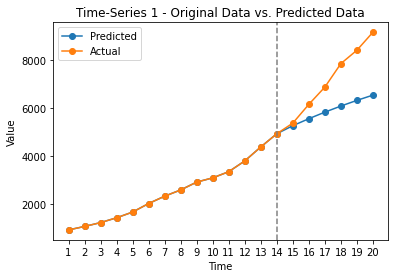

In [711]:
def plot_pred(index):
    testplt = np.append(df_micro.iloc[index][:14], predictions[index])
    plt.plot(list(range(1, 21)), testplt, marker='o', label='Predicted')
    plt.plot(list(range(1, 21)), df_micro.iloc[index].to_numpy(), marker='o', label="Actual")
    plt.axvline(x = 14, color = 'gray', linestyle='--')
    plt.title(f"Time-Series {index+1} - Original Data vs. Predicted Data")
    plt.xticks(list(range(1, 21)))
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
plot_pred(0)